Hyperparameters weren't tuned very much (I did but not much)

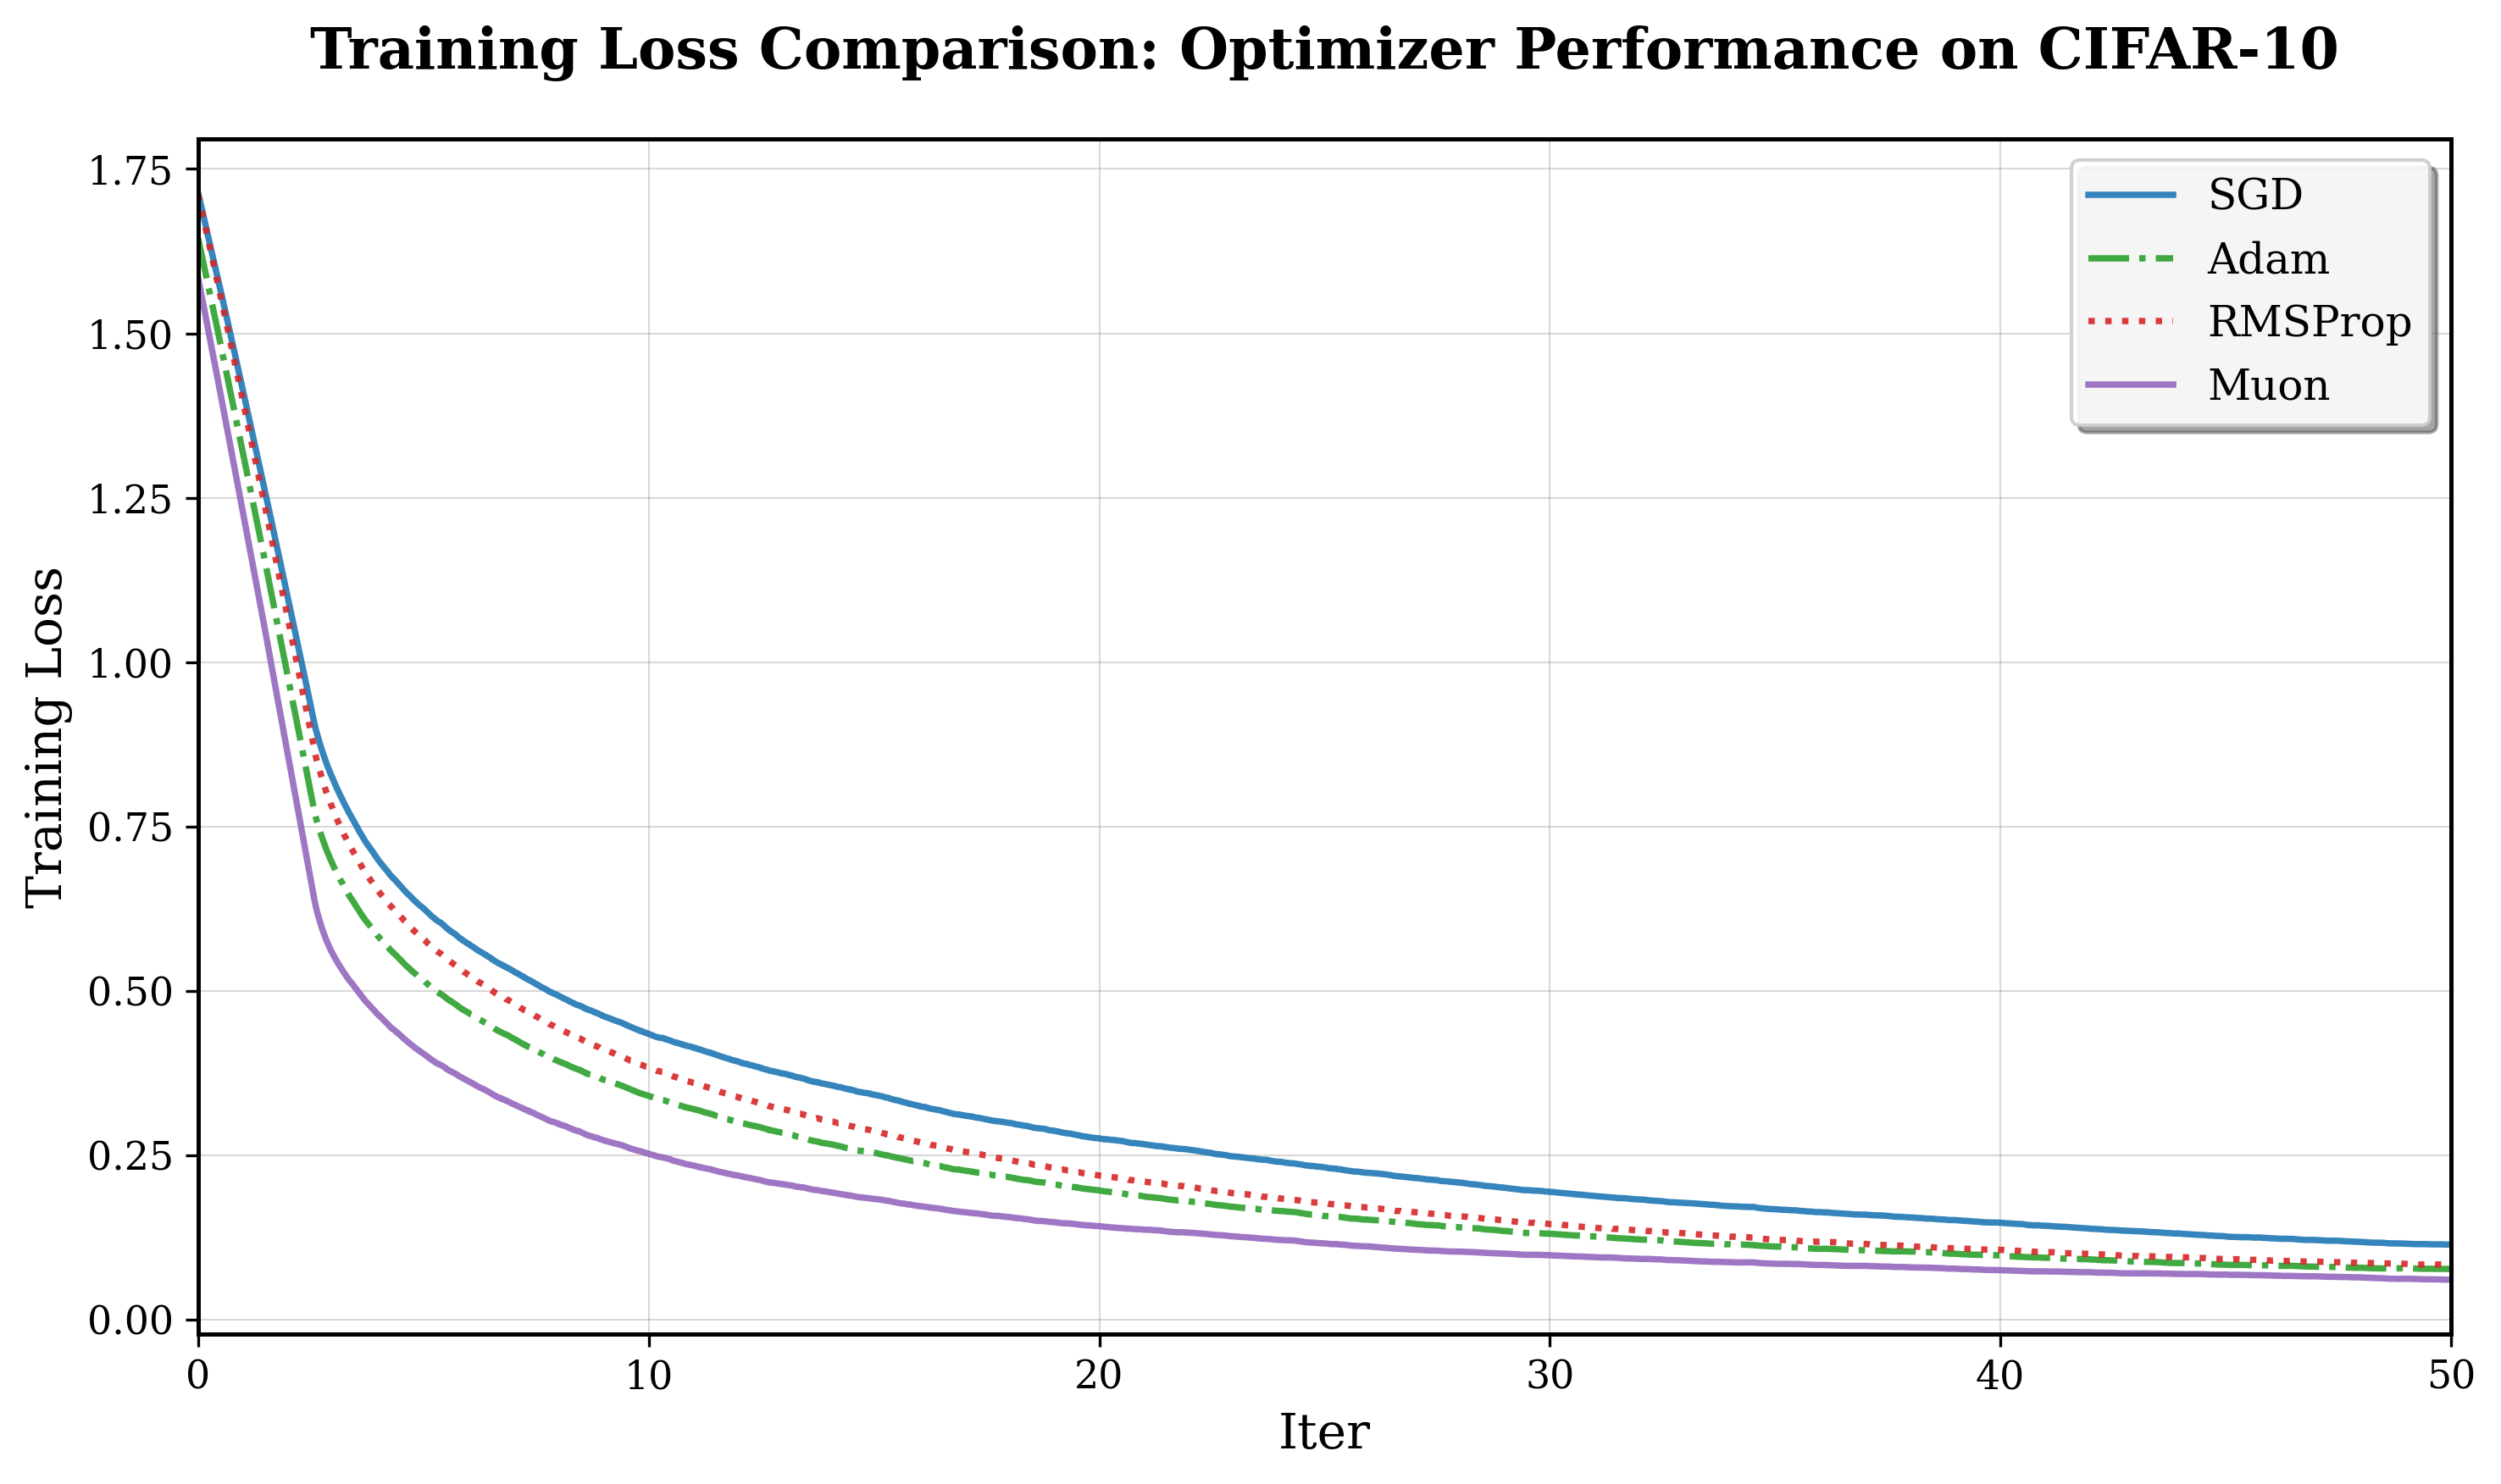
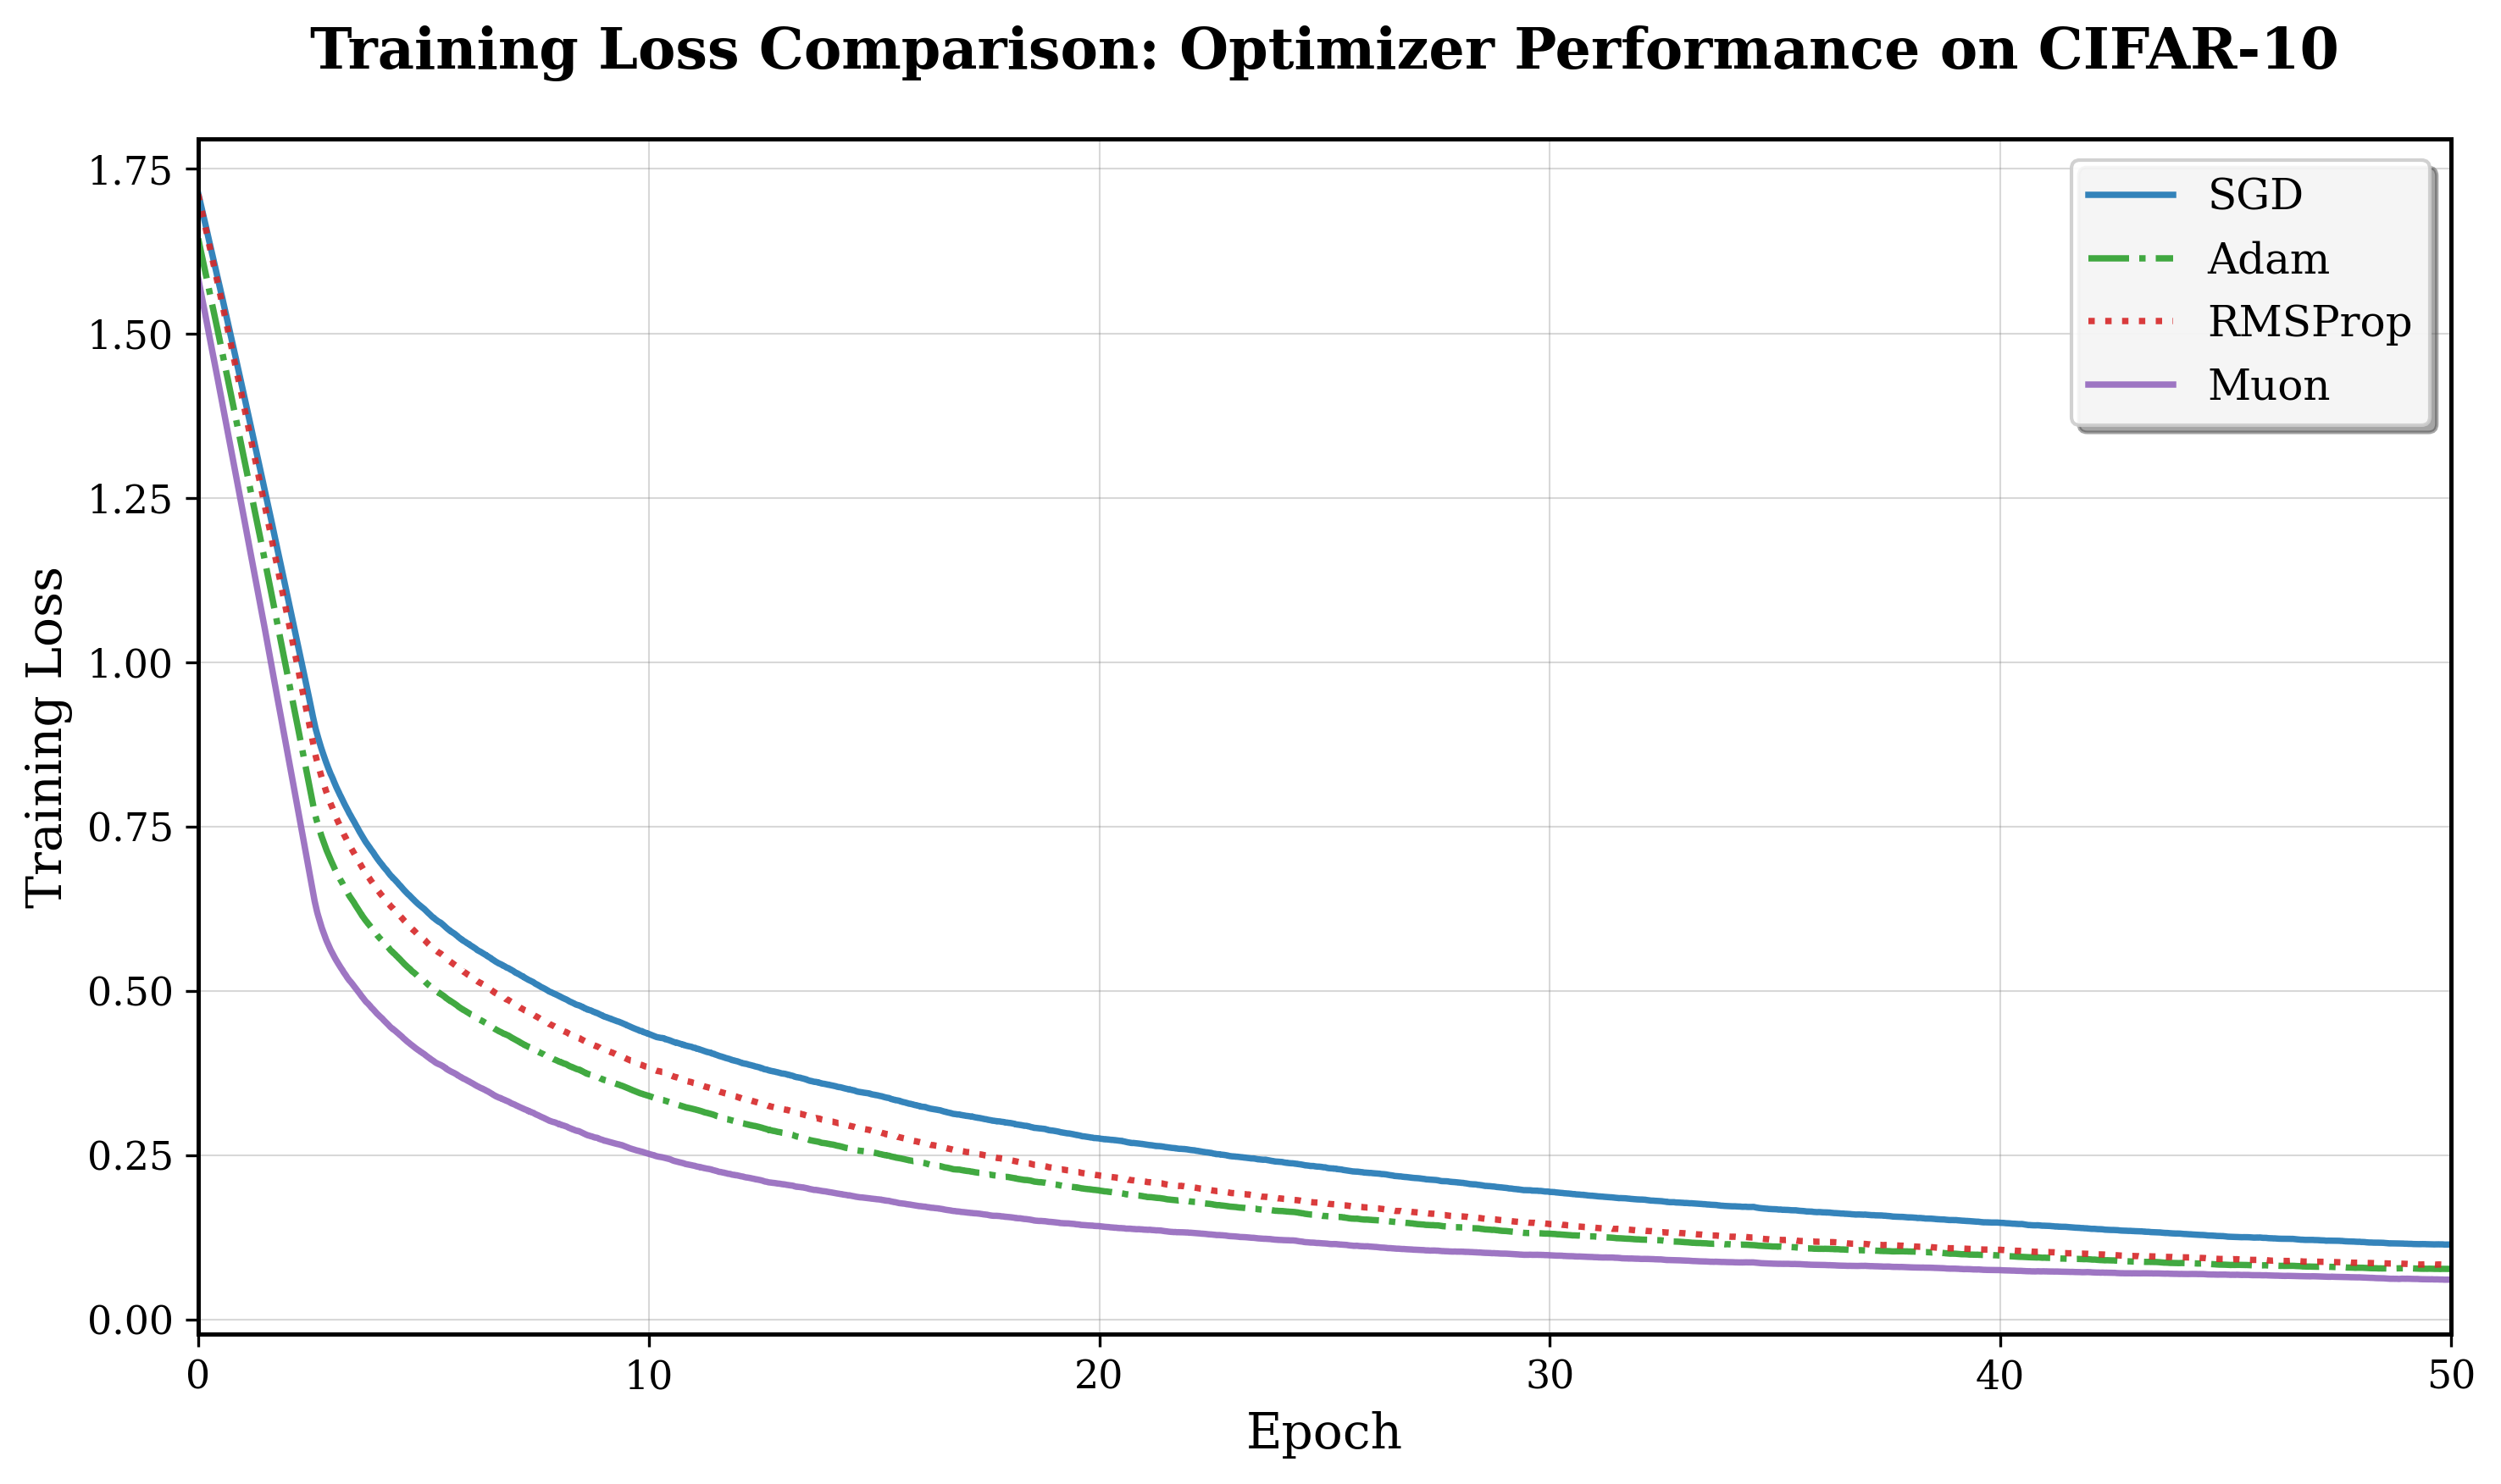

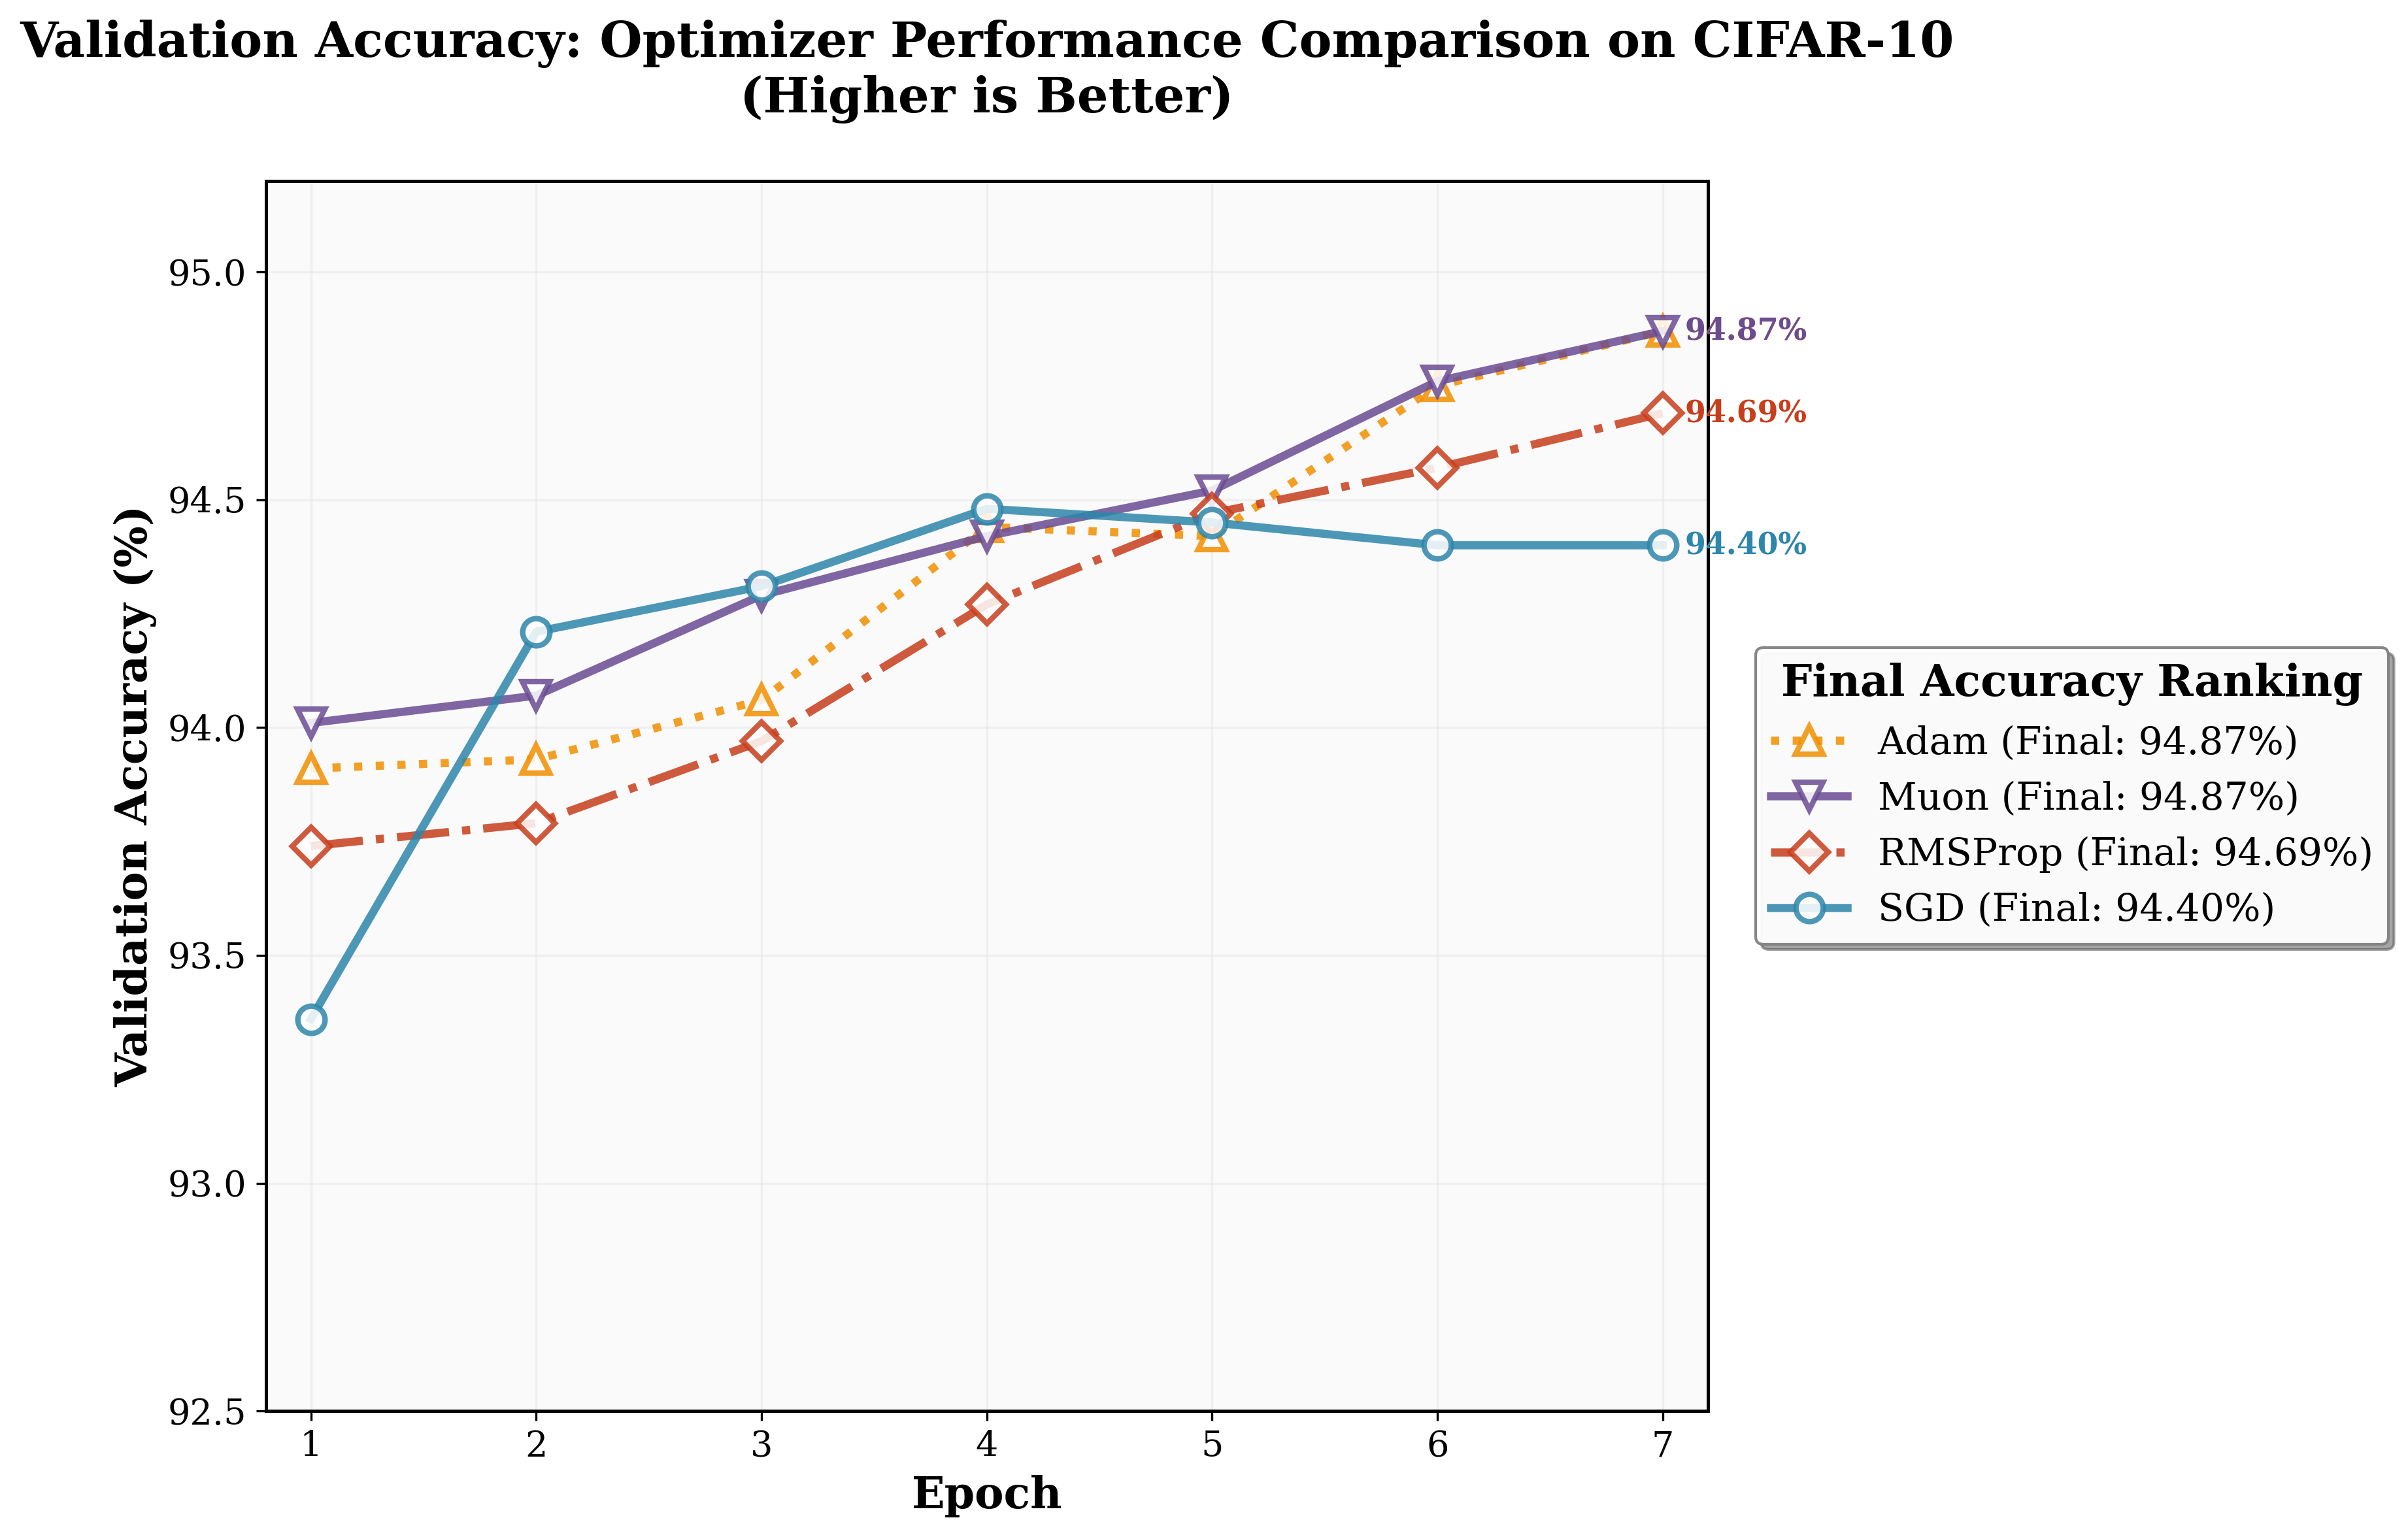

In [ ]:
import os
import sys
import uuid
from math import ceil
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(True) # getting nans for float16 for RMSProp, Adam and Muon

from optimizers.optim import SGD, SGDMomentum, RMSProp, Adam, Muon, Optimizer # My optim, not PyTorch's optim

In [ ]:
"""This cell is based on: https://github.com/KellerJordan/cifar10-airbench"""

hyp = {
    'aug': {
        'flip': True,
        'translate': 4,
        'cutout': 12,
    },
    'net': {
        'widths': {
            'block1': 128,
            'block2': 384,
            'block3': 512,
        },
        'depth': 3,
        'scaling_factor': 1/9,
        'tta_level': 2,         # the level of test-time augmentation: 0=none, 1=mirror, 2=mirror+translate
    },
}

#############################################
#                DataLoader                 #
#############################################

CIFAR_MEAN = torch.tensor((0.4914, 0.4822, 0.4465))
CIFAR_STD = torch.tensor((0.2470, 0.2435, 0.2616))

def batch_flip_lr(inputs):
    flip_mask = (torch.rand(len(inputs), device=inputs.device) < 0.5).view(-1, 1, 1, 1)
    return torch.where(flip_mask, inputs.flip(-1), inputs)

def batch_crop(images, crop_size):
    r = (images.size(-1) - crop_size)//2
    shifts = torch.randint(-r, r+1, size=(len(images), 2), device=images.device)
    images_out = torch.empty((len(images), 3, crop_size, crop_size), device=images.device, dtype=images.dtype)
    # The two cropping methods in this if-else produce equivalent results, but the second is faster for r > 2.
    if r <= 2:
        for sy in range(-r, r+1):
            for sx in range(-r, r+1):
                mask = (shifts[:, 0] == sy) & (shifts[:, 1] == sx)
                images_out[mask] = images[mask, :, r+sy:r+sy+crop_size, r+sx:r+sx+crop_size]
    else:
        images_tmp = torch.empty((len(images), 3, crop_size, crop_size+2*r), device=images.device, dtype=images.dtype)
        for s in range(-r, r+1):
            mask = (shifts[:, 0] == s)
            images_tmp[mask] = images[mask, :, r+s:r+s+crop_size, :]
        for s in range(-r, r+1):
            mask = (shifts[:, 1] == s)
            images_out[mask] = images_tmp[mask, :, :, r+s:r+s+crop_size]
    return images_out

def make_random_square_masks(inputs, size):
    is_even = int(size % 2 == 0)
    n,c,h,w = inputs.shape

    # seed top-left corners of squares to cutout boxes from, in one dimension each
    corner_y = torch.randint(0, h-size+1, size=(n,), device=inputs.device)
    corner_x = torch.randint(0, w-size+1, size=(n,), device=inputs.device)

    # measure distance, using the center as a reference point
    corner_y_dists = torch.arange(h, device=inputs.device).view(1, 1, h, 1) - corner_y.view(-1, 1, 1, 1)
    corner_x_dists = torch.arange(w, device=inputs.device).view(1, 1, 1, w) - corner_x.view(-1, 1, 1, 1)

    mask_y = (corner_y_dists >= 0) * (corner_y_dists < size)
    mask_x = (corner_x_dists >= 0) * (corner_x_dists < size)

    final_mask = mask_y * mask_x

    return final_mask

def batch_cutout(inputs, size):
    cutout_masks = make_random_square_masks(inputs, size)
    return inputs.masked_fill(cutout_masks, 0)

def set_random_state(seed, state):
    if seed is None:
        # If we don't get a data seed, then make sure to randomize the state using independent generator, since
        # it might have already been set by the model seed.
        import random
        torch.manual_seed(random.randint(0, 2**63))
    else:
        seed1 = 1000 * seed + state # just don't do more than 1000 epochs or else there will be overlap
        torch.manual_seed(seed1)

class InfiniteCifarLoader:
    """
    CIFAR-10 loader which constructs every input to be used during training during the call to __iter__.
    The purpose is to support cross-epoch batches (in case the batch size does not divide the number of train examples),
    and support stochastic iteration counts in order to preserve perfect linearity/independence.
    """

    def __init__(self, path, train=True, batch_size=500, aug=None, altflip=True, subset_mask=None, aug_seed=None, order_seed=None):
        data_path = os.path.join(path, 'train.pt' if train else 'test.pt')
        self._ds = dset = torchvision.datasets.CIFAR10(path, download=True, train=train)
        if not os.path.exists(data_path):
            dset = torchvision.datasets.CIFAR10(path, download=True, train=train)
            images = torch.tensor(dset.data)
            labels = torch.tensor(dset.targets)
            torch.save({'images': images, 'labels': labels, 'classes': dset.classes}, data_path)

        data = torch.load(data_path, map_location='cuda')
        self.images, self.labels, self.classes = data['images'], data['labels'], data['classes']
        # It's faster to load+process uint8 data than to load preprocessed fp16 data
        self.images = (self.images / 255).permute(0, 3, 1, 2).to(memory_format=torch.channels_last)

        self.normalize = T.Normalize(CIFAR_MEAN, CIFAR_STD)

        self.aug = aug or {}
        for k in self.aug.keys():
            assert k in ['flip', 'translate', 'cutout'], 'Unrecognized key: %s' % k

        self.batch_size = batch_size
        self.altflip = altflip
        self.subset_mask = subset_mask if subset_mask is not None else torch.tensor([True]*len(self.images)).cuda()
        self.train = train
        self.aug_seed = aug_seed
        self.order_seed = order_seed

    def __iter__(self):

        # Preprocess
        images0 = self.normalize(self.images)
        # Pre-randomly flip images in order to do alternating flip later.
        if self.aug.get('flip', False) and self.altflip:
            set_random_state(self.aug_seed, 0)
            images0 = batch_flip_lr(images0)
        # Pre-pad images to save time when doing random translation
        pad = self.aug.get('translate', 0)
        if pad > 0:
            images0 = F.pad(images0, (pad,)*4, 'reflect')
        labels0 = self.labels

        # Iterate forever
        epoch = 0
        batch_size = self.batch_size

        # In the below while-loop, we will repeatedly build a batch and then yield it.
        num_examples = self.subset_mask.sum().item()
        current_pointer = num_examples
        batch_images = torch.empty(0, 3, 32, 32, dtype=images0.dtype, device=images0.device)
        batch_labels = torch.empty(0, dtype=labels0.dtype, device=labels0.device)
        batch_indices = torch.empty(0, dtype=labels0.dtype, device=labels0.device)

        while True:

            # Assume we need to generate more data to add to the batch.
            assert len(batch_images) < batch_size

            # If we have already exhausted the current epoch, then begin a new one.
            if current_pointer >= num_examples:
                # If we already reached the end of the last epoch then we need to generate
                # a new augmented epoch of data (using random crop and alternating flip).
                epoch += 1

                set_random_state(self.aug_seed, epoch)
                if pad > 0:
                    images1 = batch_crop(images0, 32)
                if self.aug.get('flip', False):
                    if self.altflip:
                        images1 = images1 if epoch % 2 == 0 else images1.flip(-1)
                    else:
                        images1 = batch_flip_lr(images1)
                if self.aug.get('cutout', 0) > 0:
                    images1 = batch_cutout(images1, self.aug['cutout'])

                set_random_state(self.order_seed, epoch)
                indices = (torch.randperm if self.train else torch.arange)(len(self.images), device=images0.device)

                # The effect of doing subsetting in this manner is as follows. If the permutation wants to show us
                # our four examples in order [3, 2, 0, 1], and the subset mask is [True, False, True, False],
                # then we will be shown the examples [2, 0]. It is the subset of the ordering.
                # The purpose is to minimize the interaction between the subset mask and the randomness.
                # So that the subset causes not only a subset of the total examples to be shown, but also a subset of
                # the actual sequence of examples which is shown during training.
                indices_subset = indices[self.subset_mask[indices]]
                current_pointer = 0

            # Now we are sure to have more data in this epoch remaining.
            # This epoch's remaining data is given by (images1[current_pointer:], labels0[current_pointer:])
            # We add more data to the batch, up to whatever is needed to make a full batch (but it might not be enough).
            remaining_size = batch_size - len(batch_images)

            # Given that we want `remaining_size` more training examples, we construct them here, using
            # the remaining available examples in the epoch.

            extra_indices = indices_subset[current_pointer:current_pointer+remaining_size]
            extra_images = images1[extra_indices]
            extra_labels = labels0[extra_indices]
            current_pointer += remaining_size
            batch_indices = torch.cat([batch_indices, extra_indices])
            batch_images = torch.cat([batch_images, extra_images])
            batch_labels = torch.cat([batch_labels, extra_labels])

            # If we have a full batch ready then yield it and reset.
            if len(batch_images) == batch_size:
                assert len(batch_images) == len(batch_labels)
                yield (batch_indices, batch_images, batch_labels)
                batch_images = torch.empty(0, 3, 32, 32, dtype=images0.dtype, device=images0.device)
                batch_labels = torch.empty(0, dtype=labels0.dtype, device=labels0.device)
                batch_indices = torch.empty(0, dtype=labels0.dtype, device=labels0.device)

############################################
#               Evaluation                 #
############################################

def infer(model, loader, tta_level=0):

    # Test-time augmentation strategy (for tta_level=2):
    # 1. Flip/mirror the image left-to-right (50% of the time).
    # 2. Translate the image by one pixel either up-and-left or down-and-right (50% of the time,
    #    i.e. both happen 25% of the time).
    #
    # This creates 6 views per image (left/right times the two translations and no-translation),
    # which we evaluate and then weight according to the given probabilities.

    def infer_basic(inputs, net):
        return net(inputs).clone()

    def infer_mirror(inputs, net):
        return 0.5 * net(inputs) + 0.5 * net(inputs.flip(-1))

    def infer_mirror_translate(inputs, net):
        logits = infer_mirror(inputs, net)
        pad = 1
        padded_inputs = F.pad(inputs, (pad,)*4, 'reflect')
        inputs_translate_list = [
            padded_inputs[:, :, 0:32, 0:32],
            padded_inputs[:, :, 2:34, 2:34],
        ]
        logits_translate_list = [infer_mirror(inputs_translate, net)
                                 for inputs_translate in inputs_translate_list]
        logits_translate = torch.stack(logits_translate_list).mean(0)
        return 0.5 * logits + 0.5 * logits_translate

    model.eval()
    test_images = loader.normalize(loader.images)
    infer_fn = [infer_basic, infer_mirror, infer_mirror_translate][tta_level]
    with torch.no_grad():
        return torch.cat([infer_fn(inputs, model) for inputs in test_images.split(2000)])

def evaluate(model, loader, tta_level=0):
    logits = infer(model, loader, tta_level)
    return (logits.argmax(1) == loader.labels).float().mean().item()

#############################################
#            Network Components             #
#############################################

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Mul(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
    def forward(self, x):
        return x * self.scale

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-12,
                 weight=False, bias=True):
        super().__init__(num_features, eps=eps)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias
        # Note that PyTorch already initializes the weights to one and bias to zero

class Conv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding='same', bias=False):
        super().__init__(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)

    def reset_parameters(self):
        super().reset_parameters()
        if self.bias is not None:
            self.bias.data.zero_()
        w = self.weight.data
        torch.nn.init.dirac_(w[:w.size(1)])

class ConvGroup(nn.Module):
    def __init__(self, channels_in, channels_out, depth):
        super().__init__()
        assert depth in (2, 3)
        self.depth = depth
        self.conv1 = Conv(channels_in,  channels_out)
        self.pool = nn.MaxPool2d(2)
        self.norm1 = BatchNorm(channels_out)
        self.conv2 = Conv(channels_out, channels_out)
        self.norm2 = BatchNorm(channels_out)
        if depth == 3:
            self.conv3 = Conv(channels_out, channels_out)
            self.norm3 = BatchNorm(channels_out)
        self.activ = nn.GELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.norm1(x)
        x = self.activ(x)
        if self.depth == 3:
            x0 = x
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activ(x)
        if self.depth == 3:
            x = self.conv3(x)
            x = self.norm3(x)
            x = x + x0
            x = self.activ(x)
        return x

#############################################
#            Network Definition             #
#############################################

def make_net(hyp):
    widths = hyp['widths']
    scaling_factor = hyp['scaling_factor']
    depth = hyp['depth']
    whiten_kernel_size = 2
    whiten_width = 2 * 3 * whiten_kernel_size**2
    net = nn.Sequential(
        Conv(3, whiten_width, whiten_kernel_size, padding=0, bias=True),
        nn.GELU(),
        ConvGroup(whiten_width,     widths['block1'], depth),
        ConvGroup(widths['block1'], widths['block2'], depth),
        ConvGroup(widths['block2'], widths['block3'], depth),
        nn.MaxPool2d(3),
        Flatten(),
        nn.Linear(widths['block3'], 10, bias=False),
        Mul(scaling_factor),
    )
    net = net.cuda()
    net = net.to(memory_format=torch.channels_last)
    for mod in net.modules():
        if isinstance(mod, BatchNorm):
            mod.float()
    return net

In [ ]:
def get_model():
    model:nn.Module = make_net(hyp['net'])
    model = torch.compile(model, mode='max-autotune')
    print(model)
    return model

In [ ]:
optim_classes = {
    "SGD": lambda params: SGD(list(params), learning_rate=0.1),
    "Momentum": lambda params: SGDMomentum(list(params), learning_rate=0.7, beta=0.9),
    "RMSProp": lambda params: RMSProp(list(params), learning_rate=0.001, beta2=0.99),
    "Adam": lambda params: Adam(list(params), learning_rate=0.001, beta1=0.9, beta2=0.999),
    "Muon": lambda params: Muon(list(params), learning_rate=(0.01, 0.001), beta=0.95, adam_betas=(0.9, 0.999))
}

In [ ]:
import tqdm, math

def cosine_lr(epoch:int, num_epochs:int, lr_max:float, lr_min:float=1e-4) -> float:
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * epoch / num_epochs))

def train(model:nn.Module, optimizer:Optimizer, device:torch.device, num_epochs:int, name:str):
    model.train()
    model.to(device)
    optimizer:Optimizer = optimizer(model.parameters())
    test_loader = InfiniteCifarLoader('cifar10', train=False, batch_size=2000)
    train_loader = InfiniteCifarLoader('cifar10', train=True, batch_size=128, aug=hyp['aug'],
                                       aug_seed=7, order_seed=0)
    lr_max = optimizer.lr
    losses = []; val_accs = []; val_losses = []
    try:
        for epoch in range(num_epochs):
            optimizer.lr = cosine_lr(epoch, num_epochs, lr_max)
            
            # Single progress bar for the epoch
            pbar = tqdm.tqdm(total=len(train_loader._ds), 
                           desc=f"Epoch {epoch+1}/{num_epochs}", 
                           leave=True)
            
            for tstep, (_, inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, targets)
                loss.backward()
                optimizer.step()

                pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{optimizer.lr:.4f}")
                pbar.update(1)

                losses.append(loss.item())
                if tstep >= len(train_loader._ds) - 1:
                    break
            
            pbar.close()
            
            model.eval()
            val_acc = evaluate(model, test_loader)
            print(f"| Epoch [{epoch+1}/{num_epochs}] | Loss: {sum(losses[-len(train_loader._ds):])/(len(train_loader._ds)):.4f} | Validation Accuracy: {val_acc:.4f} |")
            model.train()
            torch.save(model.state_dict(), f'ckpt/model_{name}_epoch_{epoch+1}.pt')
            val_accs.append(val_acc)
        
    except KeyboardInterrupt:
        print("Training interrupted. Saving current state...")
        torch.save(model.state_dict(), f'ckpt/model_{name}_epoch_{epoch+1}.pt')
    return losses, val_accs

In [ ]:
def save_plot(name:str, losses:list[float], val_accs:list[float], save_dir:str="ckpt"):
    os.makedirs(save_dir, exist_ok=True)
    pickle.dump(losses, open(f"{save_dir}/{name}_losses.pkl", "wb"))
    pickle.dump(val_accs, open(f"{save_dir}/{name}_val_accs.pkl", "wb"))

    plt.plot([i for i in range(1, len(losses) + 1)], losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()

    plt.plot([i for i in range(1, len(val_accs) + 1)], val_accs)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.grid(True)
    plt.show()

In [ ]:
name = "SGD"
model = get_model()
losses, val_accs = train(model, optim_classes[name], "cuda", 7, name)
save_plot(name, losses, val_accs)

SGD
```python
Epoch 1/7: 100%|██████████| 50000/50000 [04:32<00:00, 183.31it/s, loss=0.1020, lr=0.1000]
Epoch 1/7: 100%|██████████| 50000/50000 [04:32<00:00, 183.31it/s, loss=0.1020, lr=0.1000]
| Epoch [1/7] | Loss: 0.1619 | Validation Accuracy: 0.9336 |
Epoch 2/7: 100%|██████████| 50000/50000 [04:31<00:00, 184.04it/s, loss=0.0060, lr=0.0951]

| Epoch [2/7] | Loss: 0.0127 | Validation Accuracy: 0.9421 |
Epoch 3/7: 100%|██████████| 50000/50000 [04:30<00:00, 184.74it/s, loss=0.0010, lr=0.0812]

| Epoch [3/7] | Loss: 0.0021 | Validation Accuracy: 0.9431 |
Epoch 4/7: 100%|██████████| 50000/50000 [04:30<00:00, 185.10it/s, loss=0.0008, lr=0.0612]
Epoch 4/7: 100%|██████████| 50000/50000 [04:30<00:00, 185.10it/s, loss=0.0008, lr=0.0612]
| Epoch [4/7] | Loss: 0.0007 | Validation Accuracy: 0.9448 |
Epoch 5/7: 100%|██████████| 50000/50000 [04:31<00:00, 184.15it/s, loss=0.0006, lr=0.0389]
Epoch 5/7: 100%|██████████| 50000/50000 [04:31<00:00, 184.15it/s, loss=0.0006, lr=0.0389]
| Epoch [5/7] | Loss: 0.0005 | Validation Accuracy: 0.9445 |
Epoch 6/7: 100%|██████████| 50000/50000 [04:30<00:00, 184.68it/s, loss=0.0005, lr=0.0189]
Epoch 6/7: 100%|██████████| 50000/50000 [04:30<00:00, 184.68it/s, loss=0.0005, lr=0.0189]
| Epoch [6/7] | Loss: 0.0005 | Validation Accuracy: 0.9440 |
Epoch 7/7: 100%|██████████| 50000/50000 [04:30<00:00, 184.59it/s, loss=0.0005, lr=0.0050]
Epoch 7/7: 100%|██████████| 50000/50000 [04:30<00:00, 184.59it/s, loss=0.0005, lr=0.0050]
| Epoch [7/7] | Loss: 0.0005 | Validation Accuracy: 0.9440 |
```
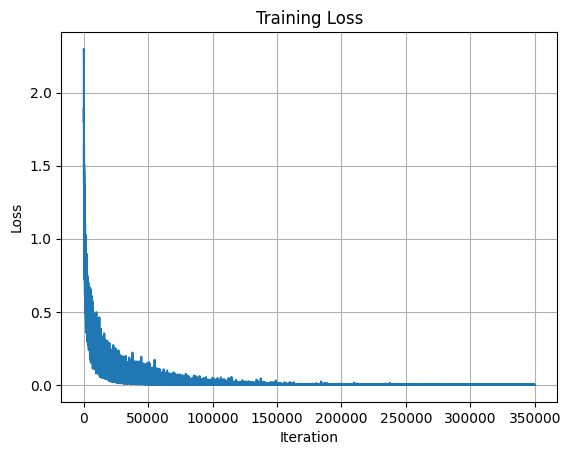
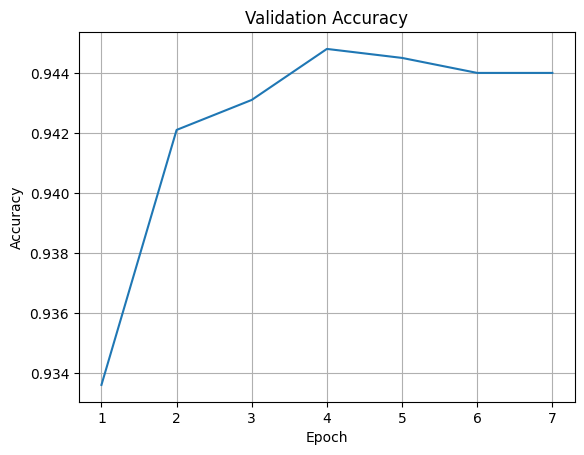

In [ ]:
name = "Momentum"
model = get_model()
losses, val_accs = train(model, optim_classes[name], "cuda", 7, name)
save_plot(name, losses, val_accs)

Momentum
```python
Epoch 1/7: 100%|██████████| 50000/50000 [04:34<00:00, 182.26it/s, loss=0.0377, lr=0.0100]
| Epoch [1/7] | Loss: 0.1620 | Validation Accuracy: 0.9339 |
Epoch 2/7: 100%|██████████| 50000/50000 [04:30<00:00, 185.07it/s, loss=0.0024, lr=0.0095]
| Epoch [2/7] | Loss: 0.0122 | Validation Accuracy: 0.9414 |
Epoch 3/7: 100%|██████████| 50000/50000 [04:28<00:00, 185.89it/s, loss=0.0019, lr=0.0081]
| Epoch [3/7] | Loss: 0.0023 | Validation Accuracy: 0.9426 |
Epoch 4/7: 100%|██████████| 50000/50000 [04:30<00:00, 185.08it/s, loss=0.0015, lr=0.0062]
| Epoch [4/7] | Loss: 0.0014 | Validation Accuracy: 0.9429 |
Epoch 5/7: 100%|██████████| 50000/50000 [04:36<00:00, 180.97it/s, loss=0.0014, lr=0.0039]
| Epoch [5/7] | Loss: 0.0013 | Validation Accuracy: 0.9432 |
Epoch 6/7: 100%|██████████| 50000/50000 [04:36<00:00, 181.01it/s, loss=0.0013, lr=0.0020]
| Epoch [6/7] | Loss: 0.0012 | Validation Accuracy: 0.9431 |
Epoch 7/7: 100%|██████████| 50000/50000 [04:35<00:00, 181.36it/s, loss=0.0013, lr=0.0006]
| Epoch [7/7] | Loss: 0.0012 | Validation Accuracy: 0.9432 |
```
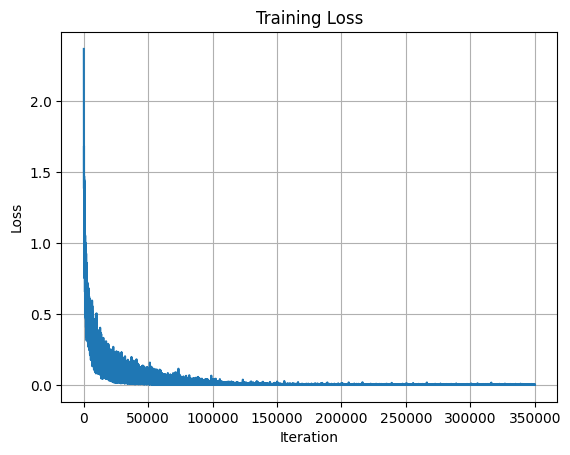
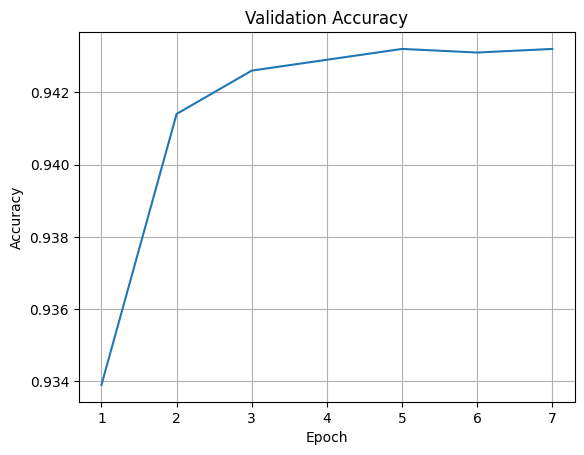

In [ ]:
name = "RMSProp"
model = get_model()
losses, val_accs = train(model, optim_classes[name], "cuda", 7, name)
save_plot(name, losses, val_accs)

RMSProp
```python
Epoch 1/7: 100%|██████████| 50000/50000 [12:53<00:00, 64.64it/s, loss=0.0375, lr=0.0010]
| Epoch [1/7] | Loss: 0.1354 | Validation Accuracy: 0.9374 |
Epoch 2/7: 100%|██████████| 50000/50000 [12:14<00:00, 68.05it/s, loss=0.0088, lr=0.0010]
| Epoch [2/7] | Loss: 0.0180 | Validation Accuracy: 0.9379 |
Epoch 3/7: 100%|██████████| 50000/50000 [12:17<00:00, 67.77it/s, loss=0.0089, lr=0.0008]
| Epoch [3/7] | Loss: 0.0084 | Validation Accuracy: 0.9397 |
Epoch 4/7: 100%|██████████| 50000/50000 [11:52<00:00, 70.18it/s, loss=0.0007, lr=0.0007]
| Epoch [4/7] | Loss: 0.0041 | Validation Accuracy: 0.9427 |
Epoch 5/7: 100%|██████████| 50000/50000 [11:50<00:00, 70.39it/s, loss=0.0003, lr=0.0004]
| Epoch [5/7] | Loss: 0.0017 | Validation Accuracy: 0.9447 |
Epoch 6/7: 100%|██████████| 50000/50000 [11:50<00:00, 70.37it/s, loss=0.0001, lr=0.0003]
| Epoch [6/7] | Loss: 0.0005 | Validation Accuracy: 0.9457 |
Epoch 7/7: 100%|██████████| 50000/50000 [11:51<00:00, 70.25it/s, loss=0.0000, lr=0.0001]
| Epoch [7/7] | Loss: 0.0001 | Validation Accuracy: 0.9469 |
```
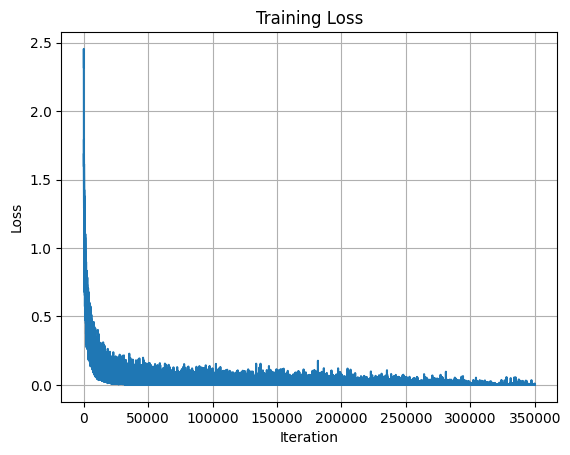
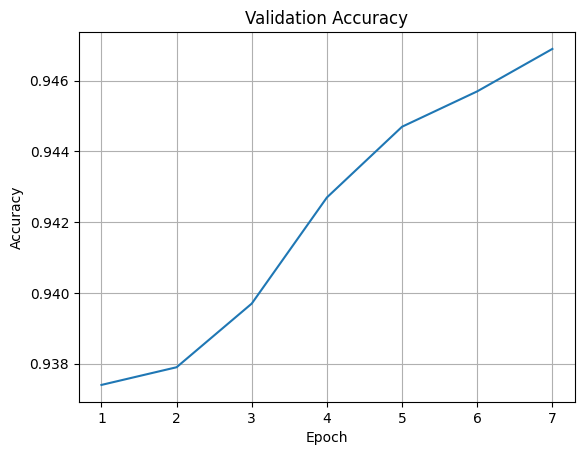



In [ ]:
name = "Adam"
model = get_model()
losses, val_accs = train(model, optim_classes[name], "cuda", 7, name)
save_plot(name, losses, val_accs)

Adam
```python
Epoch 1/7: 100%|██████████| 50000/50000 [12:50<00:00, 64.88it/s, loss=0.0286, lr=0.0010]
| Epoch [1/7] | Loss: 0.1228 | Validation Accuracy: 0.9391 |
Epoch 2/7: 100%|██████████| 50000/50000 [12:48<00:00, 65.02it/s, loss=0.0163, lr=0.0010]
| Epoch [2/7] | Loss: 0.0178 | Validation Accuracy: 0.9393 |
Epoch 3/7: 100%|██████████| 50000/50000 [12:44<00:00, 65.43it/s, loss=0.0018, lr=0.0008]
| Epoch [3/7] | Loss: 0.0084 | Validation Accuracy: 0.9406 |
Epoch 4/7: 100%|██████████| 50000/50000 [12:46<00:00, 65.24it/s, loss=0.0122, lr=0.0007]
| Epoch [4/7] | Loss: 0.0043 | Validation Accuracy: 0.9444 |
Epoch 5/7: 100%|██████████| 50000/50000 [12:42<00:00, 65.54it/s, loss=0.0148, lr=0.0004]
| Epoch [5/7] | Loss: 0.0019 | Validation Accuracy: 0.9442 |
Epoch 6/7: 100%|██████████| 50000/50000 [12:44<00:00, 65.40it/s, loss=0.0000, lr=0.0003]
| Epoch [6/7] | Loss: 0.0006 | Validation Accuracy: 0.9475 |
Epoch 7/7: 100%|██████████| 50000/50000 [12:43<00:00, 65.50it/s, loss=0.0000, lr=0.0001]
| Epoch [7/7] | Loss: 0.0002 | Validation Accuracy: 0.9487 |
```
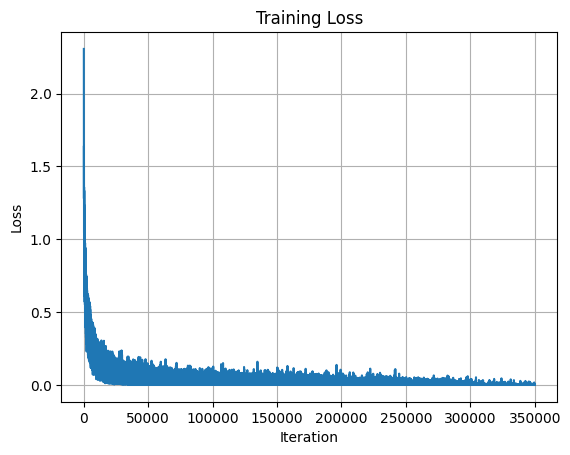
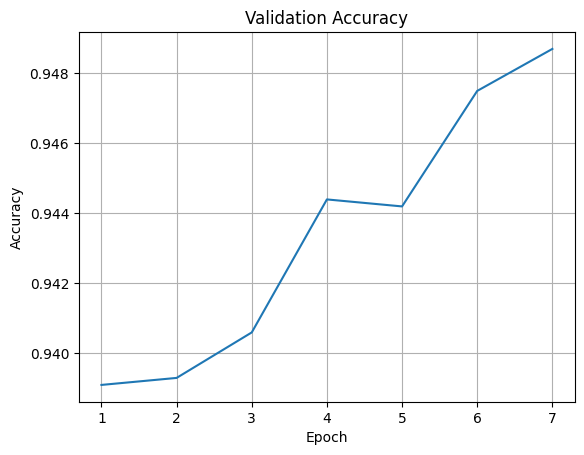

In [ ]:
name = "Muon"
model = get_model()
losses, val_accs = train(model, optim_classes[name], "cuda", 7, name)
save_plot(name, losses, val_accs)

Muon
```python
Epoch 1/7: 100%|██████████| 50000/50000 [12:37<00:00, 66.04it/s, loss=0.0044, lr=0.0100] 
| Epoch [1/7] | Loss: 0.0970 | Validation Accuracy: 0.9401 |
Epoch 2/7: 100%|██████████| 50000/50000 [11:06<00:00, 75.01it/s, loss=0.0044, lr=0.0095]
| Epoch [2/7] | Loss: 0.0155 | Validation Accuracy: 0.9407 |
Epoch 3/7: 100%|██████████| 50000/50000 [11:08<00:00, 74.79it/s, loss=0.0073, lr=0.0081]
| Epoch [3/7] | Loss: 0.0075 | Validation Accuracy: 0.9429 |
Epoch 4/7: 100%|██████████| 50000/50000 [11:12<00:00, 74.33it/s, loss=0.0018, lr=0.0062]
| Epoch [4/7] | Loss: 0.0038 | Validation Accuracy: 0.9442 |
Epoch 5/7: 100%|██████████| 50000/50000 [11:09<00:00, 74.71it/s, loss=0.0000, lr=0.0039]
| Epoch [5/7] | Loss: 0.0015 | Validation Accuracy: 0.9452 |
Epoch 6/7: 100%|██████████| 50000/50000 [11:33<00:00, 72.07it/s, loss=0.0000, lr=0.0020]
| Epoch [6/7] | Loss: 0.0005 | Validation Accuracy: 0.9476 |
Epoch 7/7: 100%|██████████| 50000/50000 [11:08<00:00, 74.78it/s, loss=0.0000, lr=0.0006]
| Epoch [7/7] | Loss: 0.0001 | Validation Accuracy: 0.9487 |
```
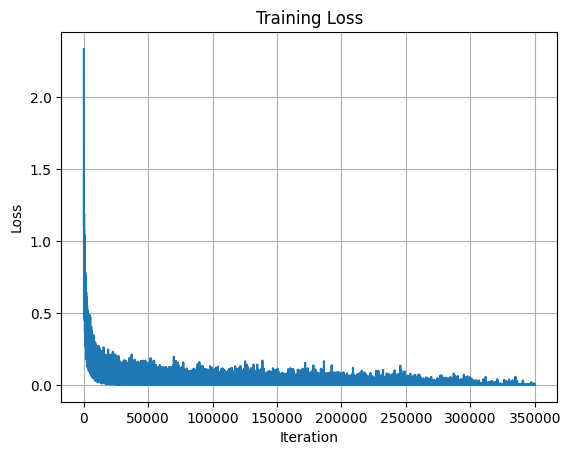
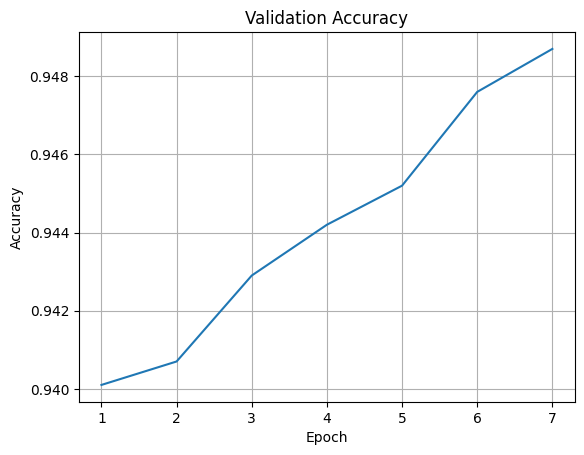